In [1]:
# NEURON simulator imports
from neuron import h, gui
from neuron.units import mV, ms, sec, um

# other essential packages
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from matplotlib.lines import Line2D


In [2]:
%matplotlib inline

In [3]:
# c compiler
!nrnivmodl

/home/gustavo/miniforge3/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/gustavo/Documents/LASCON/Project/synergisticDendrites
Mod files:

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [4]:
class Neuron():
    """
    Creates a NEURON cell instance with specific dendritic morphologies. Neurons can have passive or active
    somas and dendrites. They can be stimulated and return membrane potential recordings from pre- and post-
    synaptic stimulation sites and from the soma.
    
    Parameters
    ----------
    alpha (float): value between 0 and 1, indicating the pyramidal-likeness, as opposed to purkinje-likeness, 
                   of the dendritic morphology
    celsius (int): temperature in Celsius
    maxTreeLength (float): maximum length of dendritic tree in microns
    Vrest (float): resting potential in mV
    Cmem (float): membrane capacitance in uF cm^-2
    Rmem (float): membrane resistance in Ohm
    Ra (flat): axial resistance in Ohm
    geo (dict): geometry-defining default parameters of soma and dendritic sections
    mech (dict): mechanisms of dendrite, soma and axon Sections ('pas' for passive, or 'hh' for Hodgekin-Huxley)
    """
    
    def __init__(self,
                 alpha=0.5,
                 celsius=37,
                 Vrest=-70*mV,
                 Cmem=0.638856,
                 Rmem=120236.0,
                 Ra=141.949,
                 maxTreeLength=500*um,
                 geo={'soma': {'L':12.6157*um, 'diam': 12.6157*um, 'nseg': 5}, 
                      'dendrite': {'L': 10*um, 'diam': 1*um, 'nseg': 5}},
                 mech={'dendrite': 'pas', 'soma': 'hh', 'axon': 'pas'}):
        
        # reset h before creating a new neuron
        h('forall delete_section()')
        self.h = h
        h.celsius = celsius
        
        # set biophysical parameters (in soma)
        self.Vrest = Vrest
        self.Cmem = Cmem
        self.Rmem = Rmem
        self.Ra = Ra
        self.mech = mech

        # geometry defining parameters
        self.geo = geo
        self.alpha = alpha
        self.maxTreeLength = maxTreeLength

        # create dendritic tree storage variables
        self.dendrites = []

        # create soma, define its geometry and biophysics
        self.soma = self.createSection('soma')
        self.growDendrites()

    def __repr__(self):
        return "Neuron"

    def __str__(self):
        return "a Neuron"

    def createSection(self, type):
        # create NEURON Section instance
        num = len(self.dendrites)
        sec = h.Section(name=type+"["+str(num)+"]", cell=self)
        
        # define Section geometry
        sec.L = self.geo[type]['L']
        sec.diam = self.geo[type]['diam']
        sec.nseg = self.geo[type]['nseg']
        
        # define biophysics
        sec.insert(self.mech[type])
        sec.Ra = self.Ra*(sec.diam/self.geo['soma']['diam'])
        sec.cm = self.Cmem*(self.geo['soma']['diam']/sec.diam)
        
        # set passive biophysical parameters
        if self.mech[type]=='pas':
            sec.e_pas = self.Vrest
            sec.g_pas = (1/self.Rmem)*(self.geo['soma']['diam']/sec.diam)
            
        # set hodgekin huxley biophysical parameters
        elif self.mech[type]=='hh':
            sec.gnabar_hh = 0.12  # Sodium conductance in S/cm2
            sec.gkbar_hh = 0.036  # Potassium conductance in S/cm2
            sec.gl_hh = 0.0003    # Leak conductance in S/cm2
            sec.el_hh = -54.3     # Reversal potential in mV

        return sec

    def addBranch(self, parent):
        """Creates a new dendrite section and connects it to the end of the parent. Returns dendrite section."""
        dend = self.createSection('dendrite')
        dend.connect(parent(1), 0)
        self.dendrites.append(dend)
        return dend

    def growDendrites(self, root=None):
        # if neuron has no dendrites yet, create one and connect to soma
        if not self.dendrites:
            root = self.addBranch(self.soma)
        elif not root:
            root = self.dendrite[-1]
            
        # initialize queue with new roots that can grow into branches
        roots = [[root]]   
        count = 0
        maxCount = 300

        while roots and count<maxCount:
            # pick a root and make it the current branch
            currentBranch = roots[-1]
            branchLength = len(currentBranch)*self.geo['dendrite']['L']
            del roots[-1]
            
            # extend branch until it has reached maximum length
            while branchLength<self.maxTreeLength:
                # add a new dendrite section
                dend = self.addBranch(currentBranch[-1])
                
                # check if bifurcation occurs 
                if np.random.rand()<self.getBranchProb(branchLength):
                    # connect sister branch to parent
                    sister = self.addBranch(currentBranch[-1])
                    # add sister branch to new roots
                    roots.append(currentBranch+[sister])
                    
                # add first branch to current branch list
                currentBranch.append(dend)
                
                # update branchLength
                branchLength += self.geo['dendrite']['L']
                count += 1

    def getBranchProb(self, dist2soma):
        # sample if cell acts like pyramidal or purkinje cell
        return 1-self.alpha
        #pyramidalLike = True if np.random.rand()<self.alpha else False
        ## discretize probability distributions
        #L = self.geo['dendrite']['L']
        #d = dist2soma-L*0.5
        #if pyramidalLike:
        #    mu = 5.26
        #    sigma = 1.55
        #    return (1/(d*sigma*np.sqrt(2*np.pi)))*np.exp(-((np.log(d)-mu)**2)/(2*sigma**2))*L
        #else:
        #    return 0.5*(stats.gamma.pdf(d,a=2,scale=20)+stats.gamma.pdf(d,a=6.5,scale=30))*L

    def createSynapse(self, dendIdx, loc=0.5, tau=[2*ms, 4*ms], e=0*mV):
        """Creates an excitatory synapse on the dendrite given by Idx."""
        syn = self.h.Exp2Syn(self.dendrites[dendIdx](loc))
        syn.tau1 = tau[0]
        syn.tau2 = tau[1]
        syn.e = e
        return syn 
        
    def createStim(self, isi=20*ms, num=100, start=1*ms, noise=1, seed=9):
        stim = self.h.NetStim()
        stim.interval = isi
        stim.number = num
        stim.start = start
        stim.noise = noise
        stim.noiseFromRandom123(seed, 0, 0)
        stim.seed(seed)
        return stim

    def connectStim(self, syn, stim, delay=1*ms, weight=0.4):
        conn = self.h.NetCon(stim, syn)
        conn.delay = delay
        conn.weight[0] = weight
        return conn
    
    def simulate(self, dendIdx, seeds, 
                 loc=0.5, tau=[2*ms, 4*ms], e=0*mV, 
                 isi=20*ms, num=100, start=1*ms, stop=1000*ms, noise=1, 
                 delay=1*ms, weight=0.4):
        # get number of inputs
        numInputs = len(dendIdx)
        
        # create synapses
        synapses = [self.createSynapse(dendIdx[i], loc=loc, tau=tau, e=e) for i in range(numInputs)]

        # create inputs
        stimulations = [self.createStim(isi=isi, num=num, start=start, noise=noise, seed=seeds[i]) for i in range(numInputs)]

        # connect inputs to synapses
        connections = [self.connectStim(synapses[i], stimulations[i], delay=delay, weight=weight) for i in range(numInputs)]
        
        # prepare output variable
        recordings = {'soma': self.h.Vector(),
                      'input': [self.h.Vector() for i in range(numInputs)],
                      'inputTime': [self.h.Vector() for i in range(numInputs)],
                      'dendrite': [self.h.Vector() for i in range(numInputs)],
                      'synapse': [self.h.Vector() for i in range(numInputs)],
                      'time': self.h.Vector()}
        
        # set up recordings
        recordings['soma'].record(self.soma(0.5)._ref_v) # soma membrane potential
        recordings['time'].record(self.h._ref_t) # time steps
        for i, dend in enumerate(dendIdx):
            recordings['dendrite'][i].record(self.dendrites[dend](0.5)._ref_v)
            recordings['synapse'][i].record(synapses[i]._ref_i)
            connections[i].record(recordings['inputTime'][i], recordings['input'][i])

        # run simulation
        self.h.tstop = stop
        self.h.v_init = self.Vrest
        self.h.run() 

        # convert outputs into numpy arrays
        for k,v in recordings.items():
            if k=='soma' or k=='time':
                recordings[k] = np.array(list(recordings[k]))
            else:
                recordings[k] = [np.array(list(recordings[k][i])) for i in range(len(recordings[k]))]
        
        return recordings
        
    def getDendriteIdx(self, dist2soma):
        """Returns indices of all dendrites with a certain distance (path length) from the soma."""
        pass


In [5]:
def plotRecordings(recordings):
    # get some parameters for convenience
    numInputs = len(recordings['input'])
    stop = recordings['time'][-1]
    
    # generate colours for different inputs
    cmap = cm.get_cmap('winter')
    spacing = cmap.N//numInputs
    colours = cmap(np.arange(0, cmap.N, spacing))
    
    # create figure
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 7))
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
    
    # rasterplot with input stimuli
    for i in range(numInputs):
        ax1.vlines(recordings['inputTime'][i], i-0.4, i+0.4, colors=colours[i])  
    ax1.set_yticks(range(len(recordings['input'])))
    ax1.set_xlim(0, stop)
    ax1.set_xlabel('time (ms)')
    ax1.set_ylabel('input id')
    
    # plot membrane potential of soma
    ax2.plot(recordings['time'], recordings['soma'], color='r', label='soma')
    ax2.set_xlim(0, stop)
    ax2.set_xlabel('time (ms)')
    ax2.set_ylabel('soma Vmem (mV)')

    # plot membrane potential of dendrites
    for i in range(numInputs):
        ax3.plot(recordings['time'], recordings['dendrite'][i], color=colours[i], label='dendrite'+str(i))
    ax3.set_xlim(0, stop)
    ax3.set_xlabel('time (ms)')
    ax3.set_ylabel('dendrite Vmem (mV)')
    
    # sanity check: plot synapse current
    for i in range(numInputs):
        ax4.plot(recordings['time'], recordings['synapse'][i], color=colours[i])
    ax4.set_xlim(0, stop)
    ax4.set_xlabel('time (ms)')
    ax4.set_ylabel('synapse I (mA)')

In [6]:
def simulate_and_plot(alpha=0,                                                             # neuron parameters
                      celsius=37,                                              
                      Vrest=-70*mV,                                              
                      Cmem=0.638856,                                             
                      Rmem=120236.0,                                              
                      Ra=141.949,                                                  
                      maxTreeLength=500*um,                                        
                      geo={'soma': {'L':12.6157*um, 'diam': 12.6157*um, 'nseg': 5}, 
                           'dendrite': {'L': 10*um, 'diam': 1*um, 'nseg': 5}},      
                      mech={'dendrite': 'pas', 'soma': 'hh', 'axon': 'pas'}, 
                      loc=0.5,                                                             # synapse parameters
                      tau=[2*ms, 4*ms],   
                      e=0*mV,
                      isi=20*ms,                                                           # stimulation parameters
                      num=100,
                      start=1*ms,
                      stop=1000*ms,
                      noise=1, 
                      delay=1*ms,                                                          # connection parameters
                      weight=0.4,
                      dendIdx=[None, None],                                                # simulation parameters
                      seeds=np.random.randint(10000, size=2)):
    
    # create Neuron cell
    cell=Neuron(alpha=alpha, celsius=celsius, Vrest=Vrest, Cmem=Cmem, Rmem=Rmem, Ra=Ra, maxTreeLength=maxTreeLength, geo=geo, mech=mech) 

    # generate dendrite indices, if not set
    if not all(dendIdx):
        dendIdx = np.random.randint(len(cell.dendrites), size=len(dendIdx))
    print("stimulating dendrites: " + ', '.join(map(str, dendIdx)))

    # run simulation and get recordings
    recordings = cell.simulate(dendIdx, seeds,
                               loc=loc, tau=tau, e=e, 
                               isi=isi, num=num, start=start, stop=stop, noise=noise, 
                               delay=delay, weight=weight)
    plotRecordings(recordings)

    return cell, recordings

In [7]:
# CHANGE PARAMETERS HERE

# neuron parameters
neuronParams = dict(alpha=0.5,                                                    # pyramidal-cell-likeness of the dendritic tree
                    celsius=37,                                                   # temperature of the neuron [Celsius]
                    Vrest=-70*mV,                                                 # resting potential [mV]
                    Cmem=0.638856,                                                # membrane capacitance of the soma [S]
                    Rmem=120236.0,                                                # membrane resistance of the soma [Ohm]
                    Ra=141.949,                                                   # axial resistance of the soma [Ohm]
                    maxTreeLength=100*um,                                         # maximum length of dendritic paths from soma [microns]
                    geo={'soma': {'L':12.6157*um, 'diam': 12.6157*um, 'nseg': 5}, # geometry-defining params
                         'dendrite': {'L': 10*um, 'diam': 1*um, 'nseg': 5}},      
                    mech={'dendrite': 'pas', 'soma': 'hh', 'axon': 'pas'})        # biophysical mechanisms

# synapse (Exp2Syn) parameters
synParams = dict(loc=0.5,            # synapse location on the dendrite (0.5 for middle, if nseg is odd)
                 tau=[2*ms, 4*ms],   # synaptic time constants
                 e=0*mV)             # synapse reversal potential

# input stimulus (NetStim) parameters
stimParams = dict(isi=70*ms,         # mean interspike time interval
                  num=10,            # average number of spikes
                  start=1*ms,        # stimulus start time
                  stop=1000*ms,      # simulation stop time
                  noise=1)           # noise parameter (must be a value from 0 to 1)

# connection (NetConn) parameters
connParams = dict(delay=1*ms,        # connection delay
                  weight=1)        # connection weight

# simulation parameters
numInputs = 2                                                    # number of input simuli 
simParams = dict(dendIdx=[None for i in range(numInputs)],       # indices of dendrites where to inject the stimulus ('None' for random)   
                 seeds=np.random.randint(10000, size=numInputs)) # random seeds of input stimulus noise

stimulating dendrites: 149, 194


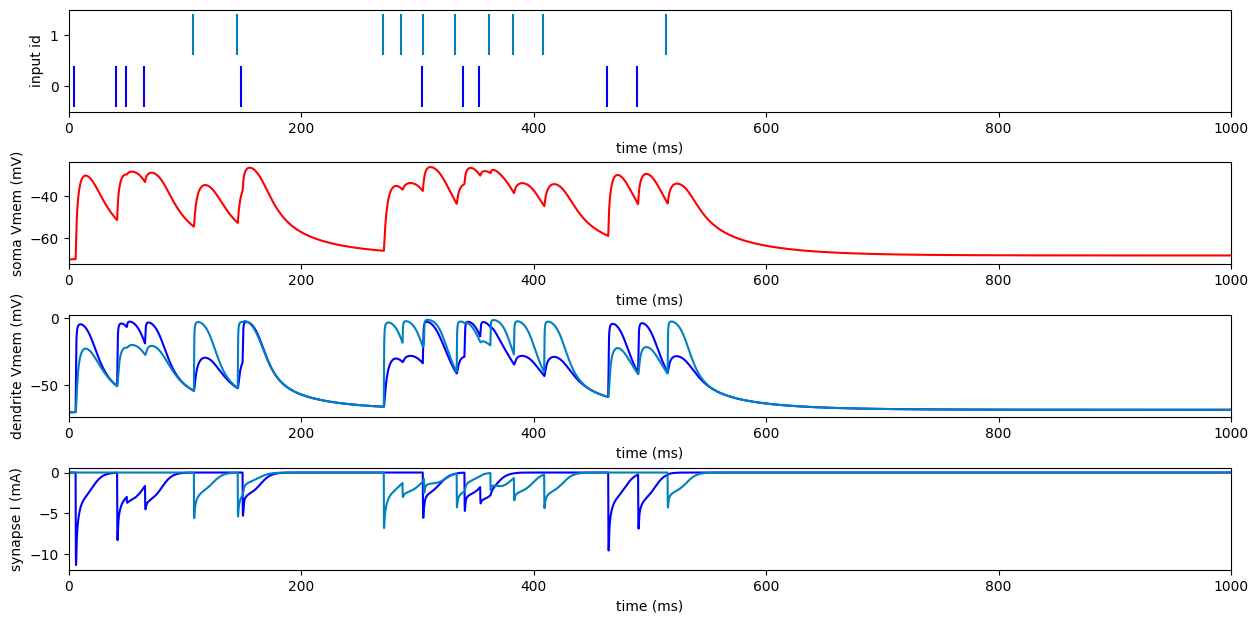

In [8]:
# run simulation and plot
cell, recording = simulate_and_plot(**neuronParams, **synParams, **stimParams, **connParams, **simParams)

In [9]:
# plot the neuron morphology
shape_window = h.Shape()
shape_window.exec_menu('Show Diam')

0.0

stimulating dendrites: 36, 55


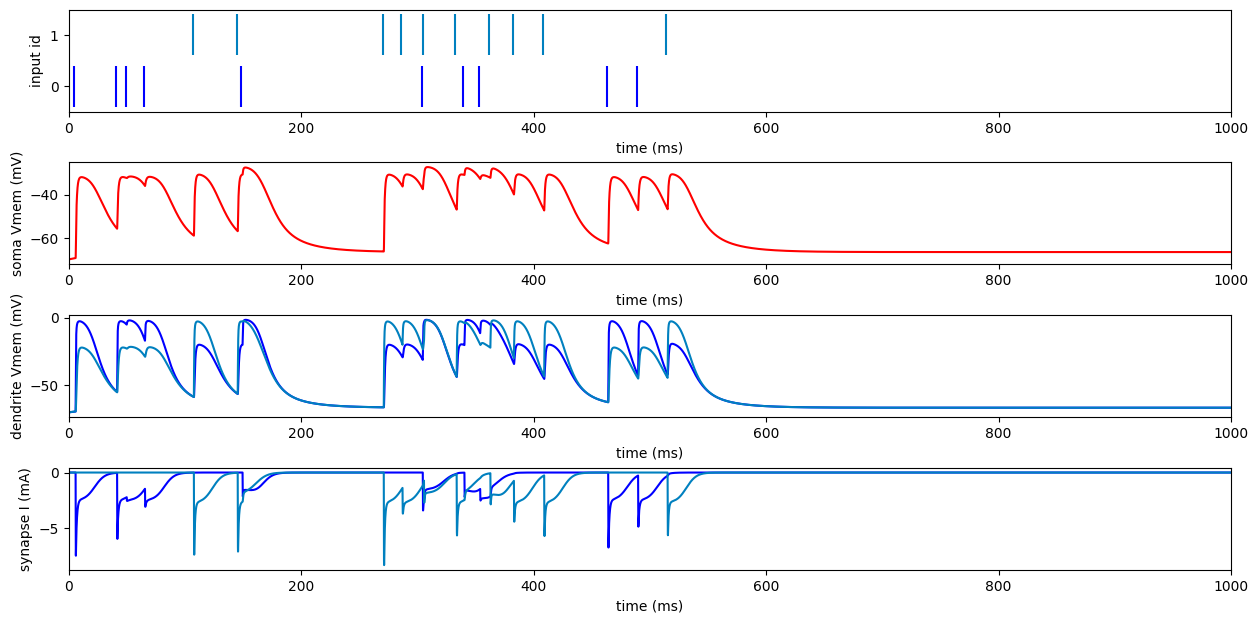

In [10]:
# run simulation and plot
cell, recording = simulate_and_plot(**neuronParams, **synParams, **stimParams, **connParams, **simParams)

### To do
- method for plotting cell morphology
- allow for creating a Neuron instance from biological morphologies
- how to set the time step of the simulation ??
- we might need some stochastic "baseline" activity in the synapses

# **TUTORIAL SPIKES**

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h , gui
from neuron.units import mV, ms, sec, um

class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.all = [self.soma, self.dend]
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                          
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
        # Insert passive current in the dendrite                       # <-- NEW
        self.dend.insert('pas')                                        # <-- NEW
        for seg in self.dend:                                          # <-- NEW
            seg.pas.g = 0.001  # Passive conductance in S/cm2          # <-- NEW
            seg.pas.e = -65    # Leak reversal potential mV            # <-- NEW 
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

def attach_current_clamp(cell, delay=5, dur=1, amp=.1, loc=1):
    """Attach a current Clamp to a cell.

    :param cell: Cell object to attach the current clamp.
    :param delay: Onset of the injected current.
    :param dur: Duration of the stimulus.
    :param amp: Magnitude of the current.
    :param loc: Location on the dendrite where the stimulus is placed.
    """
    stim = h.IClamp(cell.dend(loc))
    stim.delay = delay
    stim.dur = dur
    stim.amp = amp
    return stim

def set_recording_vectors(cell):
    """Set soma, dendrite, and time recording vectors on the cell.

    :param cell: Cell to record from.
    :return: the soma, dendrite, and time vectors as a tuple.
    """
    soma_v_vec = h.Vector()   # Membrane potential vector at soma
    dend_v_vec = h.Vector()   # Membrane potential vector at dendrite
    t_vec = h.Vector()        # Time stamp vector
    soma_v_vec.record(cell.soma(0.5)._ref_v)
    dend_v_vec.record(cell.dend(0.5)._ref_v)
    t_vec.record(h._ref_t)
    return soma_v_vec, dend_v_vec, t_vec
...
def simulate(tstop=25):
    """Initialize and run a simulation.

    :param tstop: Duration of the simulation.
    """
    h.tstop = tstop
    h.run()

def show_output(soma_v_vec, dend_v_vec, t_vec, new_fig=True):
    """Draw the output.

    :param soma_v_vec: Membrane potential vector at the soma.
    :param dend_v_vec: Membrane potential vector at the dendrite.
    :param t_vec: Timestamp vector.
    :param new_fig: Flag to create a new figure (and not draw on top
            of previous results)
    """
    if new_fig:
        plt.figure(figsize=(8,4)) # Default figsize is (8,6)
    soma_plot = plt.plot(t_vec, soma_v_vec, color='black')
    dend_plot = plt.plot(t_vec, dend_v_vec, color='red')
    plt.legend(soma_plot + dend_plot, ['soma', 'dend(0.5)'])
    plt.xlabel('time (ms)')
    plt.ylabel('mV')


In [11]:
cell = BallAndStick(0)

h.psection(sec=cell.dend)


BallAndStick[0].dend { nseg=1  L=200  Ra=100
	BallAndStick[0].soma connect BallAndStick[0].dend (0), 1
	/* First segment only */
	insert morphology { diam=1}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-65}
}


1.0

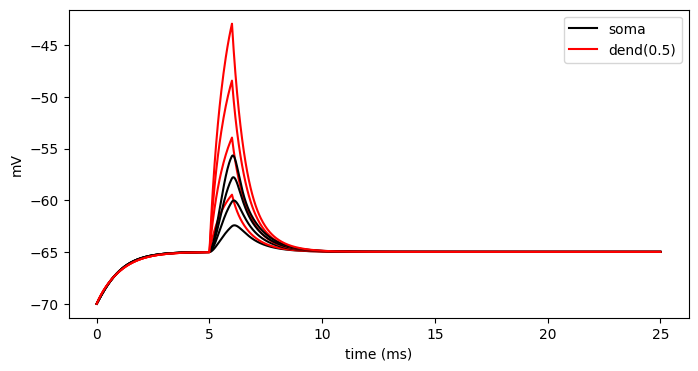

In [12]:

stim = attach_current_clamp(cell)
soma_v_vec, dend_v_vec, t_vec = set_recording_vectors(cell)

step = 0.075

num_steps = 4

for i in np.linspace(step, step*num_steps, num_steps):
    
    stim.amp = i
    
    simulate()
    # When i==step, we are at the first time through.
    show_output(soma_v_vec, dend_v_vec, t_vec, i==step)

plt.show()


# MORPHOLOGY

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from neuron import h, gui
from neuron.units import mV, ms, sec, um

%matplotlib inline


In [2]:
def createSynapse(dendIdx, loc=0.5, tau=[2*ms, 4*ms], e=0*mV):
    """Creates an excitatory synapse on the dendrite given by Idx."""
    syn = h.Exp2Syn(dend[dendIdx](loc))
    syn.tau1 = tau[0]
    syn.tau2 = tau[1]
    syn.e = e
    return syn 

def createStim(isi=20*ms, num=100, start=1*ms, noise=1, seed=9):
    stim = h.NetStim()
    stim.interval = isi
    stim.number = num
    stim.start = start
    stim.noise = noise
    stim.noiseFromRandom123(seed, 0, 0)
    stim.seed(seed)
    
    return stim

def connectStim(syn, stim, delay=1*ms, weight=0.4):
    conn = h.NetCon(stim, syn)
    conn.delay = delay
    conn.weight[0] = weight
    
    return conn


In [3]:

filename = "DATA/Pyrp22.hoc"

h.load_file(filename) 

allsec = h.allsec()


In [4]:
Vrest = -70*mV

# membrane properties are defined here */
membranecap = 0.638856    # specific membrane capacitance in uF cm^-2 */
membraneresist = 120236.0 # specific membrane resistance in ohm cm^2 */
axialresist = 141.949     # axial resistivity in ohm cm */

# dend sections
dend = [s for s in allsec if s.name().startswith('dend')]

for sec in dend:
    
    sec.insert('pas')
    sec.e_pas=Vrest
    sec.g_pas = 5.34/membraneresist
    
    sec.Ra = axialresist
    sec.cm = 5.34*membranecap

Soma = [s for s in allsec if s.name().startswith('soma')]

for sec in Soma:

    sec.insert('hh')
    
    sec.Ra = axialresist
    sec.cm = 1.0*membranecap

    for seg in sec:
        seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
        seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        seg.hh.gl = 0.0003    # Leak conductance in S/cm2
        seg.hh.el = -54.3     # Reversal potential in mV


In [5]:
tau = [2,4]

numInputs = 10

isi=200*ms                                                           # stimulation parameters

num=100

start=1*ms
stop=1000*ms
noise=1
delay=1*ms                                                          # connection parameters
weight=0.4                                                # simulation parameters
seeds=np.random.randint(10000, size=numInputs)


In [6]:
#h.topology()

In [7]:
import pandas as pd

List = pd.read_csv("DATA/Section_List.csv")

Pyrp22 = List[(List['Cell']=="Pyrp22")&(List['Names'].str.contains("dend"))]

rangeL = [0,100]

SecNames = Pyrp22[(Pyrp22['L']>rangeL[0])&(Pyrp22['L']<rangeL[1])].Names.values

#DenSel = []

#for dd in SecNames:
#    DenSel.append(eval('h.'+dd))

dendIdx0 = []

for i in range(len(dend)):
    sec = dend[i]
    if str(sec) in SecNames:
        dendIdx0.append(i)
        

In [8]:

sl = h.SectionList([sec for sec in h.allsec() if str(sec) in SecNames])

for sec in sl:
    sec.v = 0

ps = h.PlotShape(sl,False)  # False tells h.PlotShape not to use NEURON's gui

ps.scale(-80, 40)
ps.variable('v')

ax = ps.plot(pyplot, cmap=cm.jet)

pyplot.show()


<Figure size 640x480 with 0 Axes>

In [9]:
print(numInputs,len(dendIdx0),numInputs < len(dendIdx0))

10 205 True


In [10]:

dendIdx = np.random.choice(dendIdx0,numInputs)

loc = 0.5
e = 0


In [11]:
# create synapses
synapses = [createSynapse(dendIdx[i], loc=loc, tau=tau, e=e) for i in range(numInputs)]

# create inputs
stimulations = [createStim(isi=isi, num=num, start=start, noise=noise, seed=seeds[i]) for i in range(numInputs)]

# connect inputs to synapses
connections = [connectStim(synapses[i], stimulations[i], delay=delay, weight=weight) for i in range(numInputs)]

# prepare output variable
recordings = {'soma': h.Vector(),
              'input': [h.Vector() for i in range(numInputs)],
              'inputTime': [h.Vector() for i in range(numInputs)],
              'dendrite': [h.Vector() for i in range(numInputs)],
              'synapse': [h.Vector() for i in range(numInputs)],
              'time': h.Vector()}

# set up recordings
recordings['soma'].record(Soma[0](0.5)._ref_v) # soma membrane potential
recordings['time'].record(h._ref_t) # time steps

for i, dend0 in enumerate(dendIdx):
    recordings['dendrite'][i].record(dend[dend0](0.5)._ref_v)
    recordings['synapse'][i].record(synapses[i]._ref_i)
    connections[i].record(recordings['inputTime'][i], recordings['input'][i])


In [12]:
tstop = 1000*ms

h.tstop = tstop
h.run()


0.0

In [13]:
# convert outputs into numpy arrays
for k,v in recordings.items():
    if k=='soma' or k=='time':
        recordings[k] = np.array(list(recordings[k]))
    else:
        recordings[k] = [np.array(list(recordings[k][i])) for i in range(len(recordings[k]))]


/tmp/ipykernel_33053/1245016853.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('winter')


Text(0, 0.5, 'input id')

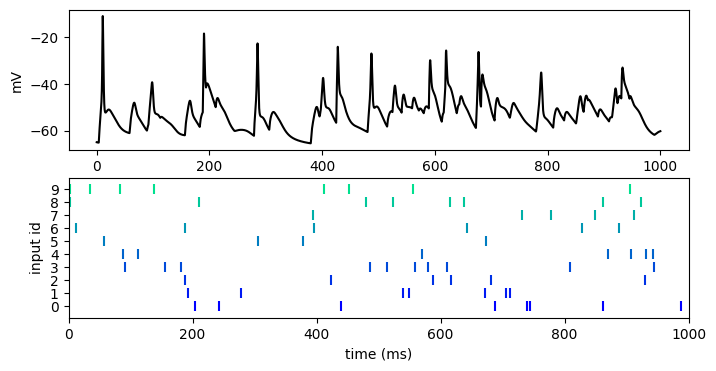

In [14]:
fig,ax = pyplot.subplots(2,1,figsize=(8,4)) # Default figsize is (8,6)

soma_plot = ax[0].plot(recordings["time"], recordings["soma"], color='black')

ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('mV')

cmap = cm.get_cmap('winter')
spacing = cmap.N//numInputs

colours = cmap(np.arange(0, cmap.N, spacing))
    
# rasterplot with input stimuli
for i in range(numInputs):
    ax[1].vlines(recordings['inputTime'][i], i-0.4, i+0.4, colors=colours[i])  
ax[1].set_yticks(range(len(recordings['input'])))
ax[1].set_xlim(0, stop)
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('input id')
